In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

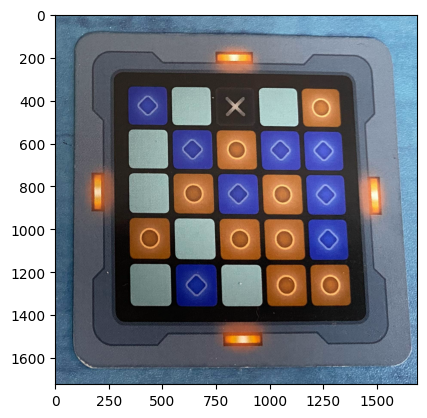

In [2]:
img = cv2.imread('assets/color_card.jpg')
plt.imshow(img)
plt.show()

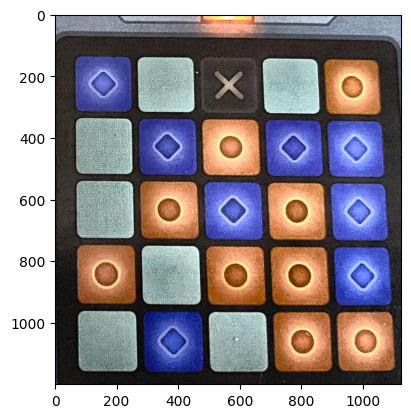

In [3]:
# this block is used to try and remove brightness/lighting problems
def preprocess_img(img):
  # Convert the image to LAB color space
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  # Split the LAB image into its 3 channels
  l, a, b = cv2.split(lab)

  # Apply CLAHE to the L channel
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  cl = clahe.apply(l)

  # Merge the CLAHE-enhanced L channel with the original A and B channels
  # This helps increase the overall brightness of the image
  limg = cv2.merge((cl,a,b))

  # Convert the image back to BGR color space
  processed_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  return processed_img 

# Show the result
processed_img = preprocess_img(img[200:1400, 275:1400])
plt.imshow(processed_img)
plt.show()


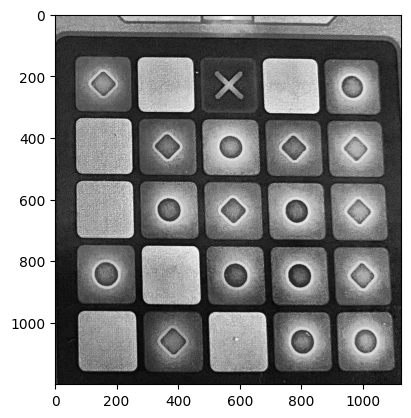

In [4]:
gray_processed = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_processed, cmap="gray", vmin=0, vmax=255)

In [5]:
lower_blue = np.array([100,150,50])
upper_blue = np.array([140,255,255])

lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])

lower_beige = np.array([20, 10, 150])
upper_beige = np.array([40, 70, 255])

# lower was originally 0, 0, 0
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 255, 30])



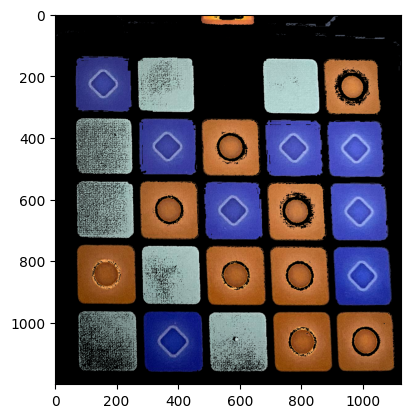

In [6]:
# convert images to HSV standard
red_img = cv2.cvtColor(img.copy()[200:1400, 275:1400], cv2.COLOR_BGR2HSV)
blue_img = cv2.cvtColor(img.copy()[200:1400, 275:1400], cv2.COLOR_BGR2HSV)
beige_img = cv2.cvtColor(processed_img.copy(), cv2.COLOR_BGR2HSV)
black_img = cv2.cvtColor(processed_img.copy(), cv2.COLOR_BGR2HSV)

# find each individual color
red_mask = cv2.inRange(red_img, lower_red, upper_red)
blue_mask = cv2.inRange(blue_img, lower_blue, upper_blue)
beige_mask = cv2.inRange(beige_img, lower_beige, upper_beige)
black_mask = cv2.inRange(black_img, lower_black, upper_black)
combined_mask = red_mask+ beige_mask + blue_mask

# this isolates the colored squares on the board --> still need to find the black square somehow
isolated_colors = cv2.bitwise_and(img[200:1400, 275:1400], img[200:1400, 275:1400], mask=combined_mask)

plt.imshow(isolated_colors)

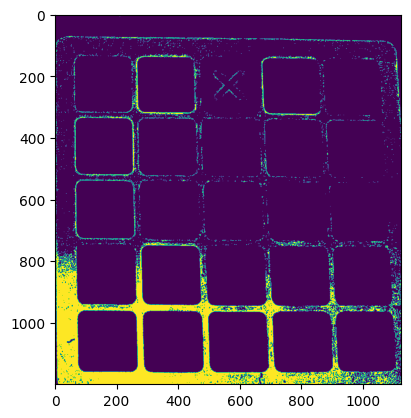

In [7]:
plt.imshow(black_mask)
plt.show()

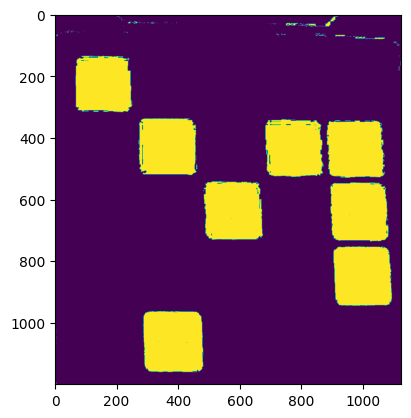

In [8]:
plt.imshow(red_mask)
plt.show()

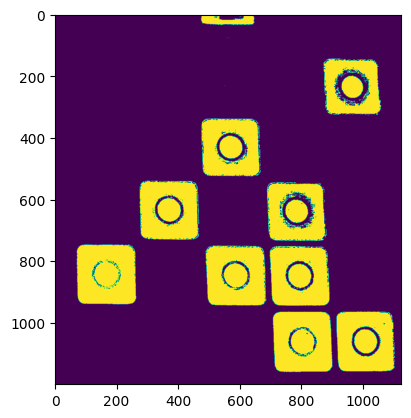

In [9]:
plt.imshow(blue_mask)
plt.show()

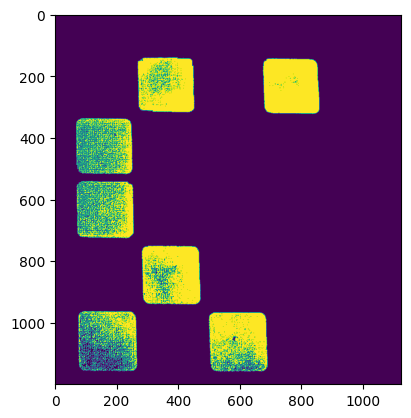

In [10]:
plt.imshow(beige_mask)
plt.show()

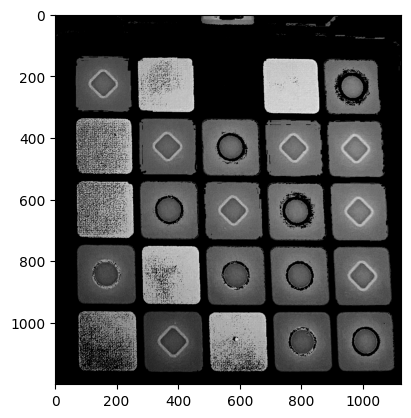

In [11]:

# when trying to find the black X, maybe if I can isolate every square, pass each square to an algorithm that can try and detect an X in it that could work
gray = cv2.cvtColor(isolated_colors, cv2.COLOR_BGR2GRAY)

# Show the result
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)

[(0, 284, 962), (1, 487, 749), (2, 74, 962), (3, 69, 745), (4, 704, 963), (5, 694, 751), (6, 273, 539), (7, 497, 965), (8, 911, 963), (9, 280, 750), (10, 901, 751), (11, 472, 337), (12, 685, 543), (13, 479, 540), (14, 890, 544), (15, 68, 540), (16, 269, 336), (17, 680, 339), (18, 879, 343), (19, 67, 336), (20, 266, 139), (21, 672, 142), (22, 65, 134), (23, 869, 142), (24, 738, 588)]
[(22, 65, 134), (20, 266, 139), (21, 672, 142), (23, 869, 142), (16, 269, 336), (19, 67, 336), (11, 472, 337), (17, 680, 339), (18, 879, 343), (6, 273, 539), (13, 479, 540), (15, 68, 540), (12, 685, 543), (14, 890, 544), (24, 738, 588), (3, 69, 745), (1, 487, 749), (9, 280, 750), (5, 694, 751), (10, 901, 751), (0, 284, 962), (2, 74, 962), (4, 704, 963), (8, 911, 963), (7, 497, 965)]
[(22, 65, 134), (20, 266, 139), (16, 269, 336), (21, 672, 142), (23, 869, 142), (19, 67, 336), (6, 273, 539), (11, 472, 337), (17, 680, 339), (18, 879, 343), (15, 68, 540), (13, 479, 540), (12, 685, 543), (24, 738, 588), (14, 89

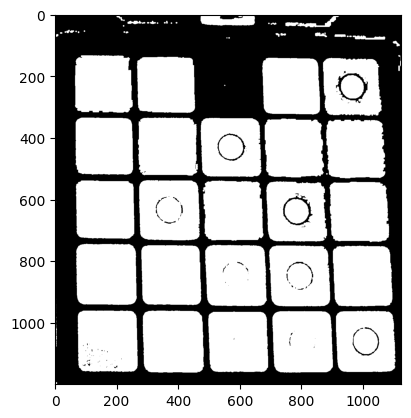

In [12]:

plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
img_h,img_w = gray.shape
background_thresh = gray[0][0]
# ADD_THRESH = 90
blur = cv2.GaussianBlur(gray,(5,5),0)
# + ADD_THRESH
total_thresh = background_thresh
_,thresh_img = cv2.threshold(blur,total_thresh,255,cv2.THRESH_BINARY)
plt.imshow(thresh_img, cmap="gray", vmin=0, vmax=255)
contours, hier = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# and cv2.contourArea(x) > (img_h * img_w)/385
#cv2.contourArea(x) < (img_h * img_w)/25 
top_25_contours = sorted(contours, key=lambda x : cv2.contourArea(x) if cv2.contourArea(x) < (img_h * img_w)/25 else 0,reverse=True)[:25]

# sort x and y later
coords_and_index = []
for i,contour in enumerate(top_25_contours):
    x, y, _, _ = cv2.boundingRect(contour)
    coords_and_index.append((i,x,y))
print(coords_and_index)
sorted_y = sorted(coords_and_index,key=lambda x:x[2])
print(sorted_y)
for i in range(5):
    sorted_y[5 * i:5* (i + 1)] = sorted(sorted_y[5 * i:5* (i + 1)], key=lambda x:x[1])
top_25_sorted = [top_25_contours[i[0]] for i in sorted_y]
print(sorted_y)

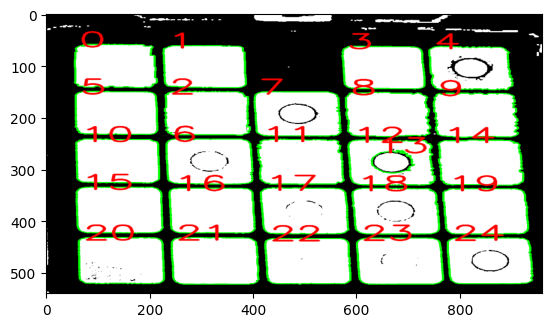

In [13]:
print_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB)
cv2.drawContours(print_img, top_25_contours, -1, (0, 255, 0), 3)

font = cv2.FONT_HERSHEY_SIMPLEX

fontScale = 3
color = (255, 0, 0)
thickness = 5
for i, place in enumerate(sorted_y):  
    cv2.putText(print_img, str(i), (place[1] + 10,place[2] + 10), font, 
                   fontScale, color, thickness, cv2.LINE_AA)

imS = cv2.resize(print_img, (960, 540)) 
plt.imshow(imS)

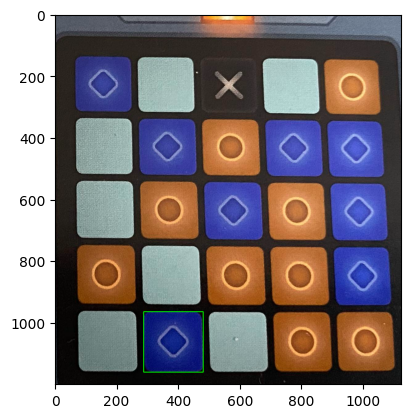

In [14]:
# Convert to grayscale
new_img = img[200:1400,275:1400]
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
ret, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

# Create a kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)

# Apply a series of morphological operations to clean up the image
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# Find contours in the image
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through each contour
for contour in contours:
    # Get the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # If the rectangle is roughly square and has a black color, it is the target square
    if new_img[y + h//2, x + w//2, 0] < 20:
        # Draw a green rectangle around the target square
        cv2.rectangle(new_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        break
    

plt.imshow(new_img)

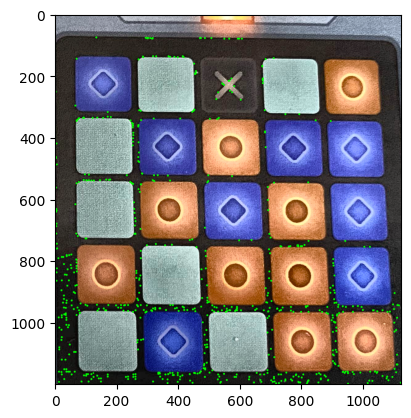

In [15]:
# Convert to grayscale
gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)

# Apply threshold to create a binary image
_, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through each contour and check if it's a square
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
    if len(approx) == 4:
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = float(w)/h
        if aspect_ratio >= 0.95 and aspect_ratio <= 1.05:
            cv2.rectangle(processed_img,(x,y),(x+w,y+h),(0,255,0),2)

# Display the result
plt.imshow(processed_img)